In [1]:
import torch 
from torch.nn import functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
import requests
from pathlib import Path

if Path('names.txt').exists():
    words = open('names.txt', 'r').read().splitlines()
else:
    req = requests.get(r'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt')
    with open('names.txt', 'wb') as f:
        f.write(req.content)
    words = open('names.txt','r').read().splitlines()

In [3]:
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [36]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [37]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(2147483647)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182677, 3]) torch.Size([182677])
torch.Size([22743, 3]) torch.Size([22743])
torch.Size([22726, 3]) torch.Size([22726])


In [38]:
#Utility function which we will use later when copamring Manual Gradients to Pytorch Gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f"{s:15s} | exact: {str(ex):5s} | approximate {str(app):5s} | maxdiff: {maxdiff}")


In [39]:
n_embd = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator = g)

W1 = torch.randn((n_embd * block_size, n_hidden), generator= g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator = g) * 0.1  # using b1 just for fun, it's useless because of BN

W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.1
b2 = torch.randn(vocab_size, generator = g) * 0.1

#BatchNorm Parameters
bngain = torch.randn((1, n_hidden), generator = g)*0.1 + 1.0
bnbias = torch.randn((1, n_hidden), generator = g) * 0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True




4137


In [40]:
batch_size = 32
n = batch_size #a shorter variable for convinence
#constrcut a minibatch
ix = torch.randint(0, Xtr.shape[0],(batch_size,), generator = g)
Xb, Yb = Xtr[ix], Ytr[ix]


In [41]:
#Forward pass,k "chunckated into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into the vector
embcat = emb.view(emb.shape[0], -1) #Concatenate the vectors

#liner layer 1 
hprebn = embcat @ W1 + b1 #hidden layer pre activation
#Batch Norm Layer
bnmeani= 1/n*hprebn.sum(0,keepdim = True) #(hprebn.sum(0,keepdim = True)/n)
bndiff = hprebn - bnmeani
bndiff2 = bndiff **2
bnvar = 1.0/(n-1)*(bndiff2).sum(0, keepdim= True) #note : Bessel's Correction (dividing by n-1 , not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw +bnbias

#Non Linearity
h = torch.tanh(hpreact) #hidden layer

#linear layer 2
logits = h @ W2 + b2 #Output Layer

#cross entropy loss (same as F.cross_Entropy loss)
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes #subtract the max for numerical stability refer the previous notebooks 
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims = True)
counts_sum_inv = counts_sum ** -1  # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

#pytorch backward pass
for p in parameters:
    p.grad = None

for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()
loss.backward()
loss



tensor(3.3087, grad_fn=<NegBackward0>)

In [42]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)

# print(h)
    
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
# cmp('bnvar', dbnvar, bnvar)
# cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
# cmp('bnmeani', dbnmeani, bnmeani)
# cmp('hprebn', dhprebn, hprebn)
# cmp('embcat', dembcat, embcat)
# cmp('W1', dW1, W1)
# cmp('b1', db1, b1)
# cmp('emb', demb, emb)
# cmp('C', dC, C)

logprobs        | exact: True  | approximate True  | maxdiff: 0.0
probs           | exact: True  | approximate True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate True  | maxdiff: 0.0
counts          | exact: True  | approximate True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate True  | maxdiff: 0.0
logits          | exact: True  | approximate True  | maxdiff: 0.0
h               | exact: True  | approximate True  | maxdiff: 0.0
W2              | exact: True  | approximate True  | maxdiff: 0.0
b2              | exact: True  | approximate True  | maxdiff: 0.0
hpreact         | exact: True  | approximate True  | maxdiff: 0.0
bngain          | exact: True  | approximate True  | maxdiff: 0.0
bnbias          | exact: True  | approximate True  | maxdiff: 0.0
bnraw           | exact: True  | approximate True  | maxdiff: 0.0
bnvar_inv 

In [43]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

In [44]:
# cmp('logprobs', dlogprobs, logprobs)
print('logprobs shape',logprobs.shape)
#calcualte the dlogprobs 
#example loss = -(a + b + c) /3 where 3 is the n 
#dloss/da = -1/3 where b and c are constatnts and will become zero so the derivative loss for n logits can be written as -1/n
print(f"Calculating the gradients for ech parameters or steps which will be used in back propagation\n")
print("the gradients that need to be updated for a step are calculated by finding the derivative from the succeeding step and\
\nwill be stored in the parameter.grad \n ")
print(f"since the most part of the logprobs which has the shape of {logprobs.shape} is gonna be zero\
     \nBecause only the logprobs[range(n), Yb] of shape {logprobs[range(n), Yb].shape} will be taken into consideration\n \
     and loss of other logits or logprobs will be derviatively - d/dx zero")

print("\n-----Implementing the derivative-----")
dlogprobs = torch.zeros_like(logprobs)
#1.0/n is the equivalent of dloss/dlogprobs
dlogprobs[range(n), Yb] = -1.0/n
cmp('logprobs', dlogprobs, logprobs)
print("\n")

# cmp('probs', dprobs, probs)
# now find the gradient of probs which will the derivative from the logprob step
print(f"derivative of probs.log() is equivalent to log(x) which is 1/x and need to implement chain rule\
      \nthat is wee need to find the derivative of probs which is dlogprobs")
print("Compare the gradients probs.grad[range(n), Yb] and dprobs[range(n), Yb]")
dprobs = (1.0/probs) * dlogprobs 
##take the derivative of the log(probs) and multiply it with the corresponding function's output i.e chain rule
print('(1.0/probs) * dlogprobs  this will boost the gradient if the predicted logits / probs of the actual value is low and\
\nwill remain the same if the prob is One')
cmp('probs',dprobs,probs)
print("\n")


## cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)


logprobs shape torch.Size([32, 27])
Calculating the gradients for ech parameters or steps which will be used in back propagation

the gradients that need to be updated for a step are calculated by finding the derivative from the succeeding step and
will be stored in the parameter.grad 
 
since the most part of the logprobs which has the shape of torch.Size([32, 27]) is gonna be zero     
Because only the logprobs[range(n), Yb] of shape torch.Size([32]) will be taken into consideration
      and loss of other logits or logprobs will be derviatively - d/dx zero

-----Implementing the derivative-----
logprobs        | exact: True  | approximate True  | maxdiff: 0.0


derivative of probs.log() is equivalent to log(x) which is 1/x and need to implement chain rule      
that is wee need to find the derivative of probs which is dlogprobs
Compare the gradients probs.grad[range(n), Yb] and dprobs[range(n), Yb]
(1.0/probs) * dlogprobs  this will boost the gradient if the predicted logits / probs

In [45]:
probs.grad[range(n), Yb]

tensor([-1.6227, -1.2678, -0.3262, -0.6133, -1.3323, -0.3412, -0.4970, -1.6078,
        -0.7497, -2.1073, -0.8495, -0.2628, -1.4616, -1.0200, -0.5024, -0.7669,
        -0.5972, -1.7127, -0.3449, -1.1309, -0.8111, -0.8258, -1.3862, -0.7505,
        -0.6523, -1.0702, -0.3213, -0.7706, -1.2941, -1.0992, -2.0321, -1.5627])

In [46]:
dprobs[range(n), Yb]

tensor([-1.6227, -1.2678, -0.3262, -0.6133, -1.3323, -0.3412, -0.4970, -1.6078,
        -0.7497, -2.1073, -0.8495, -0.2628, -1.4616, -1.0200, -0.5024, -0.7669,
        -0.5972, -1.7127, -0.3449, -1.1309, -0.8111, -0.8258, -1.3862, -0.7505,
        -0.6523, -1.0702, -0.3213, -0.7706, -1.2941, -1.0992, -2.0321, -1.5627],
       grad_fn=<IndexBackward0>)

In [47]:
counts_sum_inv.grad

tensor([[-0.3784],
        [-0.2631],
        [-0.3262],
        [-0.5020],
        [-0.3469],
        [-0.3262],
        [-0.3821],
        [-0.3348],
        [-0.2484],
        [-0.3659],
        [-0.3348],
        [-0.2628],
        [-0.2533],
        [-0.3492],
        [-0.3887],
        [-0.3549],
        [-0.3716],
        [-0.3128],
        [-0.3449],
        [-0.3348],
        [-0.3595],
        [-0.4568],
        [-0.2650],
        [-0.4497],
        [-0.3348],
        [-0.4108],
        [-0.3213],
        [-0.3499],
        [-0.3348],
        [-0.2132],
        [-0.3106],
        [-0.2792]])

In [48]:
## cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
# counts_sum_inv is 1/counts_sum
print(counts.shape, counts_sum_inv.shape)
print("the shape is not matched so it will braod cast the tensors/ logits that is the 32 columns will be broadcasted 27 times ")

# c = a * b
# a[3 x 3] * b[3x1]
# a11*b1 a12*b1 a13*b1
# a21*b2 a22*b2 a23*b2
# a31*b3 a32*b3 a33*b3

print("If we want to take the derivative of 2 fns we have to take them with respect to each other")
# da*b/da = b    ,  da*b/db = a  and multiple the chain rule of that particular function
#counts * dprobs will be of shape 32 * 27 but we nned 32 * 1 
# because thats the shape of counts_sum_inv and we are doing it by adding all the gradients across the rows
dcounts_sum_inv = (counts * dprobs).sum(1, keepdims = True)
print(f"dcount_sum_inv shape is {dcounts_sum_inv.shape}")

cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

# cmp('counts_sum', dcounts_sum, counts_sum)
#Now we have to derivate with respect to counts now

dcounts = counts_sum_inv * dprobs

print("\nwe are not checking the gradienst yet because the we calculated only the first contribution of counts\n\
`probs = counts * counts_sum_inv` we have another contribution from the counts `counts_sum = counts.sum(1, keepdims=True)`")

# derivatives of counts_sum**-1 can be writen as d(1/x)/dx = -1/x**2
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
print(f'dcounts_sum.shape = {dcounts_sum.shape}')
cmp('counts_sum', dcounts_sum, counts_sum)

#derivatives of counts.sum(1, keepdims=True)
print(f"counts.shape {counts.shape}, counts_sum.shape {counts_sum.shape}")

#a11 a12 a13 ----> b1 (= a11 + a12 + a13)
#a21 a22 a23 ----> b2 (= a21 + a22 + a23)
#a31 a32 a33 ----> b1 (= a31 + a32 + a33)
#the derivatives of b1 sould be distributed equally across its respective inputs that is a11 a12 a13 .... applied similarly to all
# we have to create a 32 x 27 from 32 x 1
#we have to add the dcounts to the first branch also
dcounts += torch.ones_like(counts) * dcounts_sum
# dcounts -> output
# tensor([[17.9747, 17.9747, 17.9747, 17.9747, 17.9747, 17.9747, 17.9747, 17.9747,
#          17.9747, 17.9747, 17.9747, 17.9747, 17.9747, 17.9747, 17.9747, 17.9747,
#          17.9747, 17.9747, 17.9747, 17.9747, 17.9747, 17.9747, 17.9747, 17.9747,
#          17.9747, 17.9747, 17.9747],
#         ...................
# after adding the branchs of counts
# tensor([[17.9747, 17.9747, 17.9747, 17.9747, 17.9747, 17.9747, 17.9747, 17.9747,
#          17.9747, 17.9747, 17.9747, 17.9747, 17.9747, 17.9747, 17.9747, 17.9747,
#          17.9747, 17.9747, 17.9747, 17.9747, 17.8570, 17.9747, 17.9747, 17.9747,
#          17.9747, 17.9747, 17.9747],
#         ...........
# dcounts
cmp('counts', dcounts, counts)

torch.Size([32, 27]) torch.Size([32, 1])
the shape is not matched so it will braod cast the tensors/ logits that is the 32 columns will be broadcasted 27 times 
If we want to take the derivative of 2 fns we have to take them with respect to each other
dcount_sum_inv shape is torch.Size([32, 1])
counts_sum_inv  | exact: True  | approximate True  | maxdiff: 0.0

we are not checking the gradienst yet because the we calculated only the first contribution of counts
`probs = counts * counts_sum_inv` we have another contribution from the counts `counts_sum = counts.sum(1, keepdims=True)`
dcounts_sum.shape = torch.Size([32, 1])
counts_sum      | exact: True  | approximate True  | maxdiff: 0.0
counts.shape torch.Size([32, 27]), counts_sum.shape torch.Size([32, 1])
counts          | exact: True  | approximate True  | maxdiff: 0.0


In [49]:
# cmp('norm_logits', dnorm_logits, norm_logits)
# local derivative of e**x is e**x

dnorm_logits = counts * dcounts  #applied chain rule
cmp('norm_logits', dnorm_logits, norm_logits)

# cmp('logit_maxes', dlogit_maxes, logit_maxes)
#norm_logits = logits - logit_maxes
print(f"shape of dnorm_logits {dnorm_logits.shape} | shape of logits {logits.shape}\
| shape of logit_maxes {logit_maxes.shape}")

dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim =True)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
dlogits.shape

# cmp('logits', dlogits, logits)
# logit_maxes  = logits.max(1, keepdim=True).values

dlogits += F.one_hot(logits.max(1).indices , num_classes = logits.shape[1]) * dlogit_maxes
dlogits
cmp('logits', dlogits, logits)


norm_logits     | exact: True  | approximate True  | maxdiff: 0.0
shape of dnorm_logits torch.Size([32, 27]) | shape of logits torch.Size([32, 27])| shape of logit_maxes torch.Size([32, 1])
logit_maxes     | exact: True  | approximate True  | maxdiff: 0.0
logits          | exact: True  | approximate True  | maxdiff: 0.0


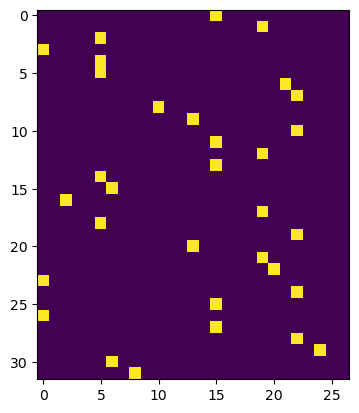

In [50]:
plt.imshow(F.one_hot(logits.max(1).indices , num_classes = logits.shape[1]))

In [51]:
# cmp('h', dh, h)
# logits = h @ W2 + b2

#we have to derivate through h @ W2 + b
# Find the derivation in the notebook for simple problem and understand it and latter apply it for the broader picture 
# Tip to know the matrix multiplication for these parameter is "Always look for the shape of the shapes of them"
# the corresponding shape of the derivative should be equal to the original shape like dh.shape == h.shape

print(f"shape of dlogits - {dlogits.shape} \n\
shape of h - {h.shape} \nshape of W2 - {W2.shape} \nshape of b2 - {b2.shape}")
dh = dlogits @ W2.T
cmp('h', dh, h)


# cmp('W2', dW2, W2)
dW2 = h.T @ dlogits
cmp('W2', dW2, W2)

# cmp('b2', db2, b2)
db2 = dlogits.sum(0)
cmp('b2', db2, b2)

# cmp('hpreact', dhpreact, hpreact)
# the derivative of tanh(x) is sech^2(x) and sech**2x = 1- tanh**2

# h = torch.tanh(hpreact)
dhpreact = (1.0 - h**2) * dh
cmp('hpreact', dhpreact, hpreact)


shape of dlogits - torch.Size([32, 27]) 
shape of h - torch.Size([32, 64]) 
shape of W2 - torch.Size([64, 27]) 
shape of b2 - torch.Size([27])
h               | exact: True  | approximate True  | maxdiff: 0.0
W2              | exact: True  | approximate True  | maxdiff: 0.0
b2              | exact: True  | approximate True  | maxdiff: 0.0
hpreact         | exact: True  | approximate True  | maxdiff: 0.0


In [52]:
# cmp('bngain', dbngain, bngain)
# hpreact = bngain * bnraw + bnbias
# Lets see the shape of dhpreat, bngain, bnraw ,bnbias

print(f"shapoe of dhpreact{dhpreact.shape} \n\
shape of bngain {bngain.shape} \nshape of bnraw {bnraw.shape} \n\
shape of bnbias {bnbias.shape}")

#hpreact = bngain * bnraw + bnbias are the element wise multiplication , Not Mat Mul , SO they are gonna be simple derivatives
# Tip look for the shapes of the local derivastive and chain rule and act accordingly
# bdnraw * dhpreact gonna be 32 x 64 , But we need it to be in the shape of bngain 1 x 64
# if the function has 1 in its dimension use keepdims = True else Not Needed
dbngain = (bnraw * dhpreact).sum(0, keepdims = True)
cmp('bngain', dbngain, bngain)

#Similarly 
# cmp('bnraw', dbnraw, bnraw)

dbnraw = bngain * dhpreact
cmp('bnraw', dbnraw, bnraw)

# cmp('bnbias', dbnbias, bnbias)
dbnbias = dhpreact.sum(0, keepdims= True)
cmp('bnbias', dbnbias, bnbias)

shapoe of dhpreacttorch.Size([32, 64]) 
shape of bngain torch.Size([1, 64]) 
shape of bnraw torch.Size([32, 64]) 
shape of bnbias torch.Size([1, 64])
bngain          | exact: True  | approximate True  | maxdiff: 0.0
bnraw           | exact: True  | approximate True  | maxdiff: 0.0
bnbias          | exact: True  | approximate True  | maxdiff: 0.0


In [63]:
# Batch Norm Layer
# bnmeani= 1/n*hprebn.sum(0,keepdim = True) #(hprebn.sum(0,keepdim = True)/n)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff **2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim= True) #note : Bessel's Correction (dividing by n-1 , not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff - bnvar_inv
# hpreact = bngain * bnraw +bnbias

print(f"shape of dbnraw {dbnraw.shape} | shape of bndiff {bndiff.shape} |\
 shape of bnvar_inv {bnvar_inv.shape}")
print(f"Broad Casting is happening because of the shape of bnvar_inv")
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdims = True)
cmp('dbnvar_inv', dbnvar_inv, bnvar_inv)

# cmp('dbndiff', dbndiff, bndiff)
dbndiff = bnvar_inv * dbnraw
cmp('dbndiff', dbndiff, bndiff)

# cmp('bnvar', dbnvar, bnvar)
# d (x ** -n ) / dx is -n * x ** -n-1
dbnvar = (-0.5) * (bnvar + 1e-5) ** -1.5 * 1 * dbnvar_inv # where 1 is the ans of derivative of (bnvar + 1e-5) w.r.t bnvar
cmp('bnvar', dbnvar, bnvar)

# cmp('bndiff2', dbndiff2, bndiff2)
print(f"shape of bnvar {bnvar.shape} | shape of dbnvar {dbnvar.shape} |\
 shape of bndiff2 {bndiff2.shape}")

#the derivativce should be of bndiff2 shape as they are squashed to 1 x 64 in the forward pass and now they should be 
# distributed to 32 while back propagating

dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar
cmp('bndiff2', dbndiff2, bndiff2)

# bndiff2 = bndiff **2
# cmp('bndiff', dbndiff, bndiff)

#the derivative of x**2 = 2x

dbndiff += (2 *bndiff) * dbndiff2
cmp('bndiff', dbndiff, bndiff) 

# bndiff = hprebn - bnmeani
print(f"shape of bndiff {bndiff.shape} | shape of hprebn {hprebn.shape} | shape of bnmeani {bnmeani.shape}")
#the broadcasting is happened during the forward pass, So we have to sum during the  back propagation
dhprebn = dbndiff.clone()
dbnmeani = (-torch.ones_like(bndiff) * dbndiff).sum(0, keepdims= True) 

cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)

# bnmeani= 1/n*hprebn.sum(0,keepdim = True) #(hprebn.sum(0,keepdim = True)/n)
# Since the values are squashed during the forward passs , we have to apply broadcasting during the back propagation

dhprebn += (1.0/n) * (torch.ones_like(hprebn) * dbnmeani)
cmp('hprebn', dhprebn, hprebn)

shape of dbnraw torch.Size([32, 64]) | shape of bndiff torch.Size([32, 64]) | shape of bnvar_inv torch.Size([1, 64])
Broad Casting is happening because of the shape of bnvar_inv
dbnvar_inv      | exact: True  | approximate True  | maxdiff: 0.0
dbndiff         | exact: False | approximate False | maxdiff: 0.0008221452008001506
bnvar           | exact: True  | approximate True  | maxdiff: 0.0
shape of bnvar torch.Size([1, 64]) | shape of dbnvar torch.Size([1, 64]) | shape of bndiff2 torch.Size([32, 64])
bndiff2         | exact: True  | approximate True  | maxdiff: 0.0
bndiff          | exact: True  | approximate True  | maxdiff: 0.0
shape of bndiff torch.Size([32, 64]) | shape of hprebn torch.Size([32, 64]) | shape of bnmeani torch.Size([1, 64])
bnmeani         | exact: True  | approximate True  | maxdiff: 0.0
hprebn          | exact: False | approximate False | maxdiff: 0.0016097391489893198
hprebn          | exact: True  | approximate True  | maxdiff: 0.0


In [68]:
#liner layer 1 
# hprebn = embcat @ W1 + b1 #hidden layer pre activation

print(f"Shape of dhprebn {dhprebn.shape}  \nshape of embcat {embcat.shape} \nshape of W1 {W1.shape}\
\nshape of b1 {b1.shape}")
#always remember the matrix derivatives Tips
dembcat = dhprebn @ W1.T
cmp('embcat', dembcat, embcat)

dW1 = embcat.T @ dhprebn
cmp('W1', dW1, W1)

db1 = dhprebn.sum(0)
cmp('b1', db1, b1)

Shape of dhprebn torch.Size([32, 64])  
shape of embcat torch.Size([32, 30]) 
shape of W1 torch.Size([30, 64])
shape of b1 torch.Size([64])
embcat          | exact: True  | approximate True  | maxdiff: 0.0
W1              | exact: True  | approximate True  | maxdiff: 0.0
b1              | exact: True  | approximate True  | maxdiff: 0.0


In [77]:
# emb = C[Xb] # embed the characters into the vector
# embcat = emb.view(emb.shape[0], -1) #Concatenate the vectors

print(f"shape of embcat {embcat.shape} | shape of emb {emb.shape}")
#shape of embcat torch.Size([32, 30]) | shape of emb torch.Size([32, 3, 10])
# 30 should be viewed as 3 x 10 , Can be achieved using view
# We can pass tuple as a input , Since embcat derived from emb , It will work
demb = dembcat.view(emb.shape)

cmp('emb', demb, emb)

# cmp('C', dC, C)
print(f"shape of emb {emb.shape} | shape of C {C.shape} | shape of Xb {Xb.shape}")
# we have to route the derivatives to each of the embeddingd of each letters in the XB
# the letters may be repetetive so they should add on if they exist more than once
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]

cmp('C', dC, C)

shape of embcat torch.Size([32, 30]) | shape of emb torch.Size([32, 3, 10])
emb             | exact: True  | approximate True  | maxdiff: 0.0
shape of emb torch.Size([32, 3, 10]) | shape of C torch.Size([27, 10]) | shape of Xb torch.Size([32, 3])
C               | exact: True  | approximate True  | maxdiff: 0.0


In [75]:
Xb[:5]

tensor([[ 0,  0, 13],
        [11,  1, 12],
        [ 1, 12,  5],
        [15, 14, 20],
        [22,  5, 15]])

In [76]:
C[0]

tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.0791,  0.9046], grad_fn=<SelectBackward0>)

In [79]:
demb[0,0]

tensor([-0.0007,  0.0060, -0.0037, -0.0003,  0.0026,  0.0029, -0.0038,  0.0028,
         0.0004,  0.0008], grad_fn=<SelectBackward0>)

In [80]:
C[0]

tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.0791,  0.9046], grad_fn=<SelectBackward0>)